# System Modeling

In this example we will see how to model an end-to-end optical system using prysm. Our system will have both an objective lens or telescope as well as a sensor with an optical low-pass filter. We begin by importing the relevant classes, numpy, and setting some visual styles:

In [1]:
import numpy as np
from prysm import FringeZernike, PSF, MTF, PixelAperture, OLPF
from matplotlib import pyplot as plt
plt.style.use('bmh')

Next we model the PSF of the objective, given its aperture, focal length, and Zernike coefficients for its wavefront, such as from a Shack-Hartmann sensor or interferometer:

In [3]:
# data from a wavefront sensor, optical design program, etc...
zernikes = [0, 0, 0, 0, 0.125, 0.125, -0.05, -0.05, 0.2]

# a pentagonal aperture inscribed in a square 10mm on a side with 50mm EFL
pupil = FringeZernike(zernikes, dia=10, mask='pentagon', opd_unit='um', norm=True)
psf = PSF.from_pupil(pupil, efl=50)

Here we have implicitly accepted the default wavelength of 0.5 microns, and Q factor of 2 (Nyquist sampling) which are usually sane defaults. The pupil is pentagonal in shape and is sufficiently described by a Zernike expansion up to Z9.

We can plot the wavefront or PSF of the objective.  The wavefront will appear to not quite fill the array, but this is just an artifact of the default lanczos interpolation and relatively few samples.

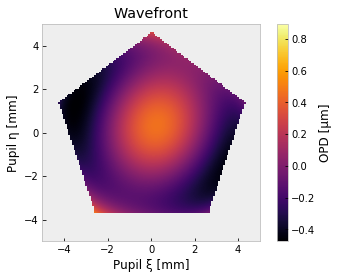

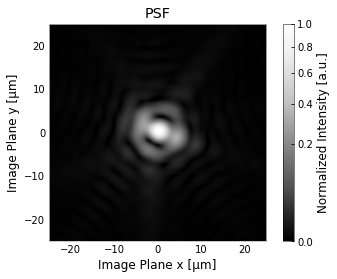

In [26]:
fig, ax = pupil.plot2d()
ax.grid(False)
ax.set_title('Wavefront')

fig, ax = psf.plot2d(axlim=25, power=2)  # 1/2 stretch, colorbar scales as well.
ax.grid(False)
ax.set_title('PSF');

or compute its MTF.  Note that "tan" and "sag" here accept the assumption of optical design code that we are looking at an object extended in Y, with no extent in X.  For example, this means we could be at an (x,y) field point of (1, 0) degrees.  On-axis, tan and sag are simply misgnomers for the "x" and "y" MTFs.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131bab43c8>)

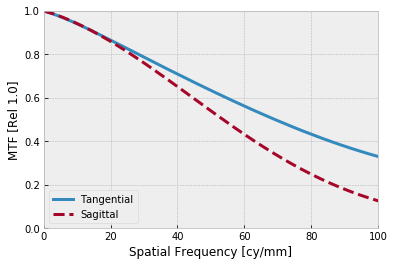

In [5]:
mtf = MTF.from_psf(psf)
mtf.plot_tan_sag(max_freq=100)

In [6]:
pixel_pitch = 5  # 5 micron pixels
aa_filter = OLPF(pixel_pitch*0.66)
pixel = PixelAperture(pixel_pitch)
sys_psf = psf.conv(aa_filter).conv(pixel)

We can plot the system PSF, which is abstract since it includes the pixel aperture.  You would not normally look at this, but prysm doesn't stop you from doing that.

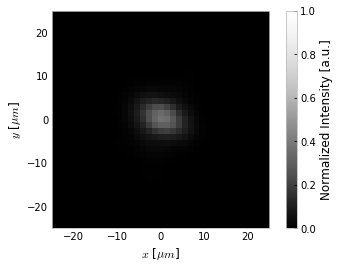

In [10]:
sys_psf.show(xlim=25)  # sys_psf is a Convolvable, not a PSF.
plt.grid(False)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131bd40ac8>)

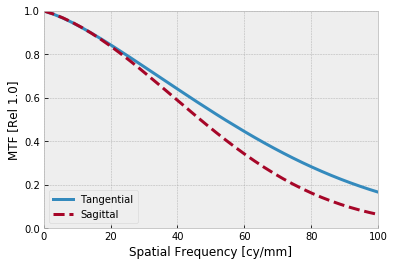

In [11]:
sys_mtf = MTF.from_psf(sys_psf)
sys_mtf.plot_tan_sag(max_freq=100)

For more information on the classes used, see `Zernikes <../user_guide/zernikes>`_, `PSFs <../user_guide/psfs>`_, `MTFs <../user_guide/mtfs>`_, and `PixelApertures, OLPFs, and convolutions <../user_guide/convolvables>`_.

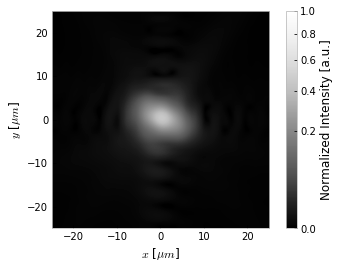

In [19]:
psf.conv(pixel).show(xlim=25, interp_method='lanczos', power=2)
#psf.show(xlim=25, interp_method='lanczos')
plt.grid(False)